In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as p
import cv2 as cv
from queue import Queue
import scipy.spatial as spatial
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image

In [2]:
# Read image, make gray scale, threshold to binary
dapitest = cv.imread('/Users/chaitanyamittal/Documents/QBI_Hackathon/mouse brain (one FOV).tif', 0)
print(dapitest.shape)
# dapiNP = np.array(dapitest)
ret, thresh1 = cv.threshold(dapitest, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

(1366, 1366)


In [3]:
grayscale = Image.fromarray(thresh1).convert('L')

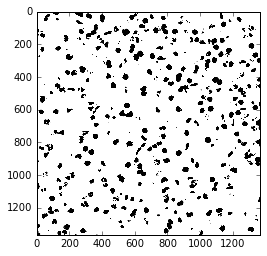

In [4]:
%matplotlib inline
plt.imshow(thresh1, 'gray')

In [5]:
plt.imshow(sample)

NameError: name 'sample' is not defined

In [6]:
def get_nuclei_centroids(img, min_nuclei_size=10):
    
    im = img.copy()
        
    shape_count = 0
        
    queue = Queue()

    shape_coords_all = []
    
    shape_size_count = []
        
    for i in range(len(im)):
        for j in range(len(im[0])):
            if im[i][j] == 0:           #if we find a black pixel, iterate count up
                shape_count += 1
                shape_coords = [(i, j)]
                im[i][j] = 1000         #mark the spot with invalid pixel so it won't be counted again
                queue.put((i, j))
                while not queue.empty():
                    cur_i, cur_j = queue.get()
                    if cur_i - 1 >= 0 and im[cur_i - 1][cur_j] == 0:
                        im[cur_i - 1][cur_j] = 1000
                        queue.put((cur_i - 1, cur_j))
                        shape_coords.append((cur_j, cur_i - 1))
                        
                    if cur_i+1 <= len(im) - 1 and im[cur_i + 1][cur_j] == 0:
                        im[cur_i + 1][cur_j] = 1000
                        queue.put((cur_i + 1, cur_j))
                        shape_coords.append((cur_j, cur_i + 1))
                        
                    if cur_j - 1 >= 0 and im[cur_i][cur_j - 1] == 0:
                        im[cur_i][cur_j - 1] = 1000
                        queue.put((cur_i, cur_j - 1))
                        shape_coords.append((cur_j - 1, cur_i))
                        
                    if cur_j + 1 <= len(im[0]) - 1 and im[cur_i][cur_j + 1] == 0:
                        im[cur_i][cur_j + 1] = 1000
                        queue.put((cur_i, cur_j + 1))  
                        shape_coords.append((cur_j + 1, cur_i))
                
                x_sum, y_sum, shape_size = 0, 0, len(shape_coords)
                shape_size_count.append(shape_size)
                for coord in shape_coords:
                    x_sum += coord[0]
                    y_sum += coord[1]
                    
                centroid = int(round(x_sum / shape_size)), int(round(y_sum / shape_size))
                
                if shape_size > min_nuclei_size:
                    shape_coords_all.append(centroid)
            
    return shape_coords_all

In [7]:
results = get_nuclei_centroids(thresh1, 30)

In [8]:
x = np.array([x for x, y in results])
y = np.array([y for x, y in results])

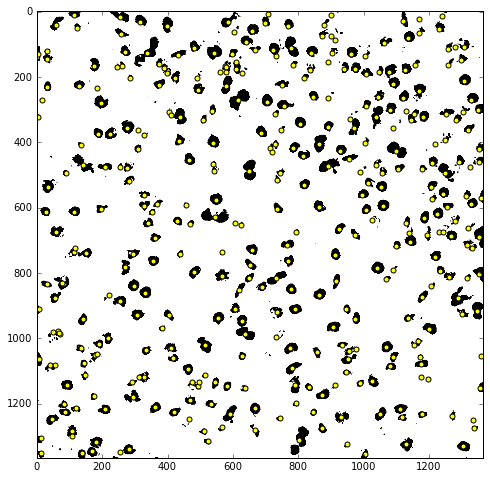

In [48]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, s = 25, c = 'yellow')
#plt.imshow(dapitest, 'gray')
plt.imshow(thresh1, 'gray')

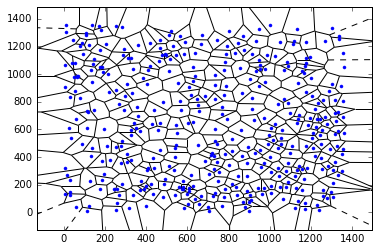

In [17]:
#perform voronoi on points
plt.figure(figsize=(20, 20))
vor = spatial.Voronoi(results)
voronoi_plot_2d(vor, show_vertices=False)
plt.show()

In [45]:
def get_polygons(vor):
    regions = vor.regions
    vertices = vor.vertices
    regions_coords = []
    
    for region in regions:
        if len(region) != 0:
            region_coord = []
            for coord in region:
                if coord != -1:
                    region_coord.append(((int(round(vertices[coord][0]))), int(round(vertices[coord][1]))))
            regions_coords.append(region_coord)
    return regions_coords

In [47]:
polygons = get_polygons(vor)

In [68]:
from cv2 import pointPolygonTest

def return_polygon_from_point(polygons, point):
    for polygon in polygons:
        if pointPolygonTest(np.array(polygon), point, False) == 1.0:
            return polygon
    return "Polygon not found"

In [69]:
print(return_polygon_from_point(polygons, (100, 500)))

[(94, 443), (38, 413), (-2, 432), (92, 556), (146, 544)]
